In [2]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext sql
conn = duckdb.connect('./data/reviews.db')
%sql conn --alias duckdb


The 'toml' package isn't installed. To load settings from pyproject.toml or ~/.jupysql/config, install with: pip install toml

In [4]:
%config SqlMagic.displaylimit = 30

In [ ]:
%sql  select   unnest(results)  from './data/p87985432_reviews.json.gz' limit 1; 

In [16]:
%sql create or replace table reviews_raw as select unnest(results) as reviews  from './data/p87985432_reviews.json.gz'

Running query in 'duckdb'

Count
17467


In [ ]:
%sql create or replace table products_raw as from './data/product_info.csv.gz'

In [7]:
%sql select unnest(reviews)  from reviews_raw limit 1

Running query in 'duckdb'

Id,CID,SourceClient,LastModeratedTime,LastModificationTime,ProductId,OriginalProductName,ContextDataValuesOrder,AuthorId,ContentLocale,IsFeatured,TotalInappropriateFeedbackCount,TotalClientResponseCount,TotalCommentCount,Photos,Rating,IsRatingsOnly,IsRecommended,Helpfulness,TotalFeedbackCount,TotalNegativeFeedbackCount,TotalPositiveFeedbackCount,ModerationStatus,SubmissionId,SubmissionTime,ReviewText,Title,UserNickname,ContextDataValues,AdditionalFields,AdditionalFieldsOrder,BadgesOrder,SecondaryRatings,TagDimensionsOrder,TagDimensions,Cons,IsSyndicated,RatingRange,CampaignId,UserLocation,Badges,ProductRecommendationIds,InappropriateFeedbackList,SecondaryRatingsOrder,ClientResponses,Videos,Pros,CommentIds
337610431,d4029aac-9588-5471-9731-038271b945c8,sephora,2025-02-14T01:02:06.000+00:00,2025-02-25T08:05:02.000+00:00,1925163,Pro Filt’r Soft Matte Longwear Liquid Foundation 140,"['IncentivizedReview', 'skinTone', 'skinType', 'eyeColor', 'hairColor']",37382674255,en_CA,False,0,0,0,"[{'Sizes': {'normal': {'Id': 'normal', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/c9296a02-393b-59d6-8e67-a2fe5048975f'}, 'thumbnail': {'Id': 'thumbnail', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/2eb7813b-8ffc-571f-af73-44376234bd06'}, 'large': {'Id': 'large', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/f330bf71-fd8f-59e2-91dc-a81b8f218104'}}, 'Id': '39246058', 'SizesOrder': ['normal', 'thumbnail', 'large'], 'Caption': 'DummyPhotoCaption'}, {'Sizes': {'normal': {'Id': 'normal', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/e3fea710-cf22-52a1-a6f6-11278d241e52'}, 'thumbnail': {'Id': 'thumbnail', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/e8a0b21d-d6bf-5055-99b5-0501be0efc8c'}, 'large': {'Id': 'large', 'Url': 'https://photos-us.bazaarvoice.com/photo/2/cGhvdG86c2VwaG9yYQ/592f3749-f973-55d4-9d56-d79222570cfc'}}, 'Id': '39246059', 'SizesOrder': ['normal', 'thumbnail', 'large'], 'Caption': 'DummyPhotoCaption'}]",5,False,True,1.0,1,0,1,APPROVED,r18723-en__17393836Lw964ldVnn,2025-02-12T18:07:06.000+00:00,"I used this product over the past few months, I am very satisfied with the matte results! Personally I like to apply moisturizer as I have normal skin type for feeling more hydrated. The coverage is pretty good and long-lasting. I recommend this productt specially for oily skin type.",Even good for bridal makeup,ManaEpicBeauty,"{'skinType': {'Value': 'normal', 'Id': 'skinType', 'ValueLabel': 'Normal', 'DimensionLabel': 'Skin Type'}, 'IncentivizedReview': {'Value': 'False', 'Id': 'IncentivizedReview', 'ValueLabel': 'No', 'DimensionLabel': 'I received this product as a free sample'}, 'skinTone': {'Value': 'light', 'Id': 'skinTone', 'ValueLabel': 'Light', 'DimensionLabel': 'Skin Tone'}, 'hairColor': {'Value': 'blonde', 'Id': 'hairColor', 'ValueLabel': 'blonde', 'DimensionLabel': 'Hair Color'}, 'eyeColor': {'Value': 'brown', 'Id': 'eyeColor', 'ValueLabel': 'Brown', 'DimensionLabel': 'Eye Color'}, 'StaffContext': None, 'age': None}","{'sociallockup': {'Value': 'avatar=https://community.sephora.com/t5/image/serverpage/image-id/2632225i1B6497028BAE4677/image-dimensions/172x172?v=v2|biBadgeUrl=/html/rank_icons/birole_insider.png|engagementBadgeUrl=/html/rank_icons/window_shopper_1.png|biTier=bi', 'Id': 'sociallockup', 'Label': 'sociallockup'}}",['sociallockup'],[],{},[],{},None,False,5,None,None,{},[],[],[],[],[],None,[]


In [34]:
%sql create or replace table reviews_clean as select reviews.contextdatavaluesorder,reviews.ContextDataValues, reviews.isfeatured, reviews.rating, reviews.isratingsonly, reviews.isrecommended, reviews.helpfulness, reviews.TotalFeedbackCount, reviews.TotalNegativeFeedbackCount, reviews.TotalPositiveFeedbackCount,reviews.reviewtext,reviews.title,reviews.ContextDataValues,reviews.ratingrange  from reviews_raw 

Running query in 'duckdb'

Count
17467


In [ ]:
%sql describe reviews_clean 

In [ ]:
%%sql
select * from reviews_clean limit 10

   rating hair_color eye_color
0       5     blonde     brown
1       4      black     brown
2       2     blonde      blue
3       1     auburn     hazel
4       5      brown     brown


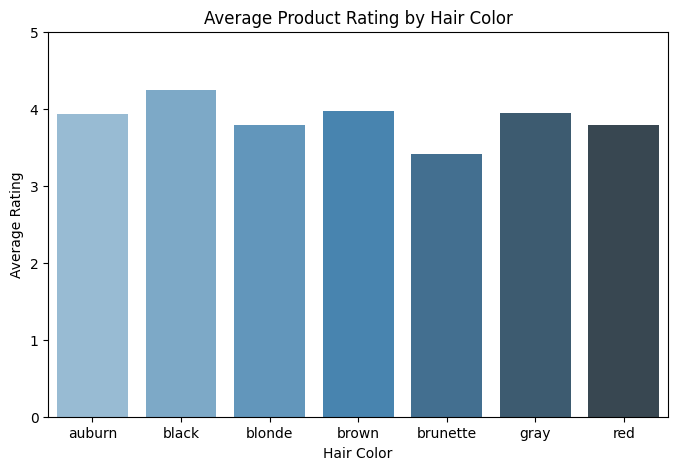

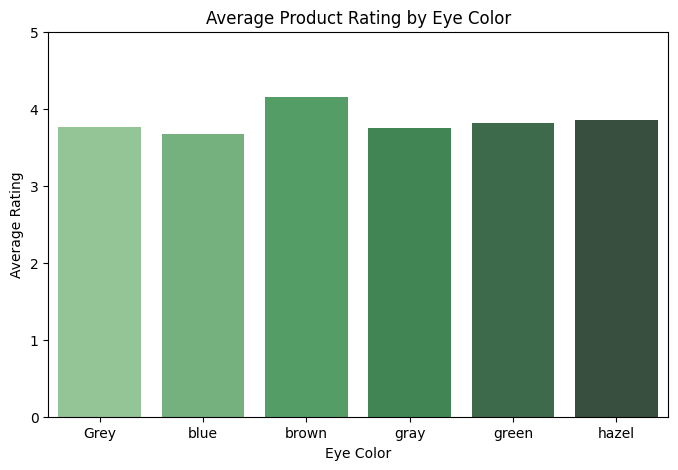

In [9]:
query = (
    """
SELECT
    rating,
    ContextDataValues.hairColor.Value AS hair_color,
    ContextDataValues.eyeColor.Value AS eye_color
FROM reviews_clean
WHERE
    ContextDataValues.hairColor.Value IS NOT NULL
    AND ContextDataValues.eyeColor.Value IS NOT NULL
"""
)
df = conn.sql(query).df()

print(df.head())

# Explore average rating by hair color
hair_avg_rating = df.groupby('hair_color')['rating'].mean().reset_index()

# Explore average rating by eye color
eye_avg_rating = df.groupby('eye_color')['rating'].mean().reset_index()

# Visualization: Hair Color vs Avg. Rating
plt.figure(figsize=(8,5))
sns.barplot(data=hair_avg_rating, x='hair_color', y='rating', palette='Blues_d')
plt.title('Average Product Rating by Hair Color')
plt.xlabel('Hair Color')
plt.ylabel('Average Rating')
plt.ylim(0,5)
plt.show()

# Visualization: Eye Color vs Avg. Rating
plt.figure(figsize=(8,5))
sns.barplot(data=eye_avg_rating, x='eye_color', y='rating', palette='Greens_d')
plt.title('Average Product Rating by Eye Color')
plt.xlabel('Eye Color')
plt.ylabel('Average Rating')
plt.ylim(0,5)
plt.show()

# Average Rating by skin type

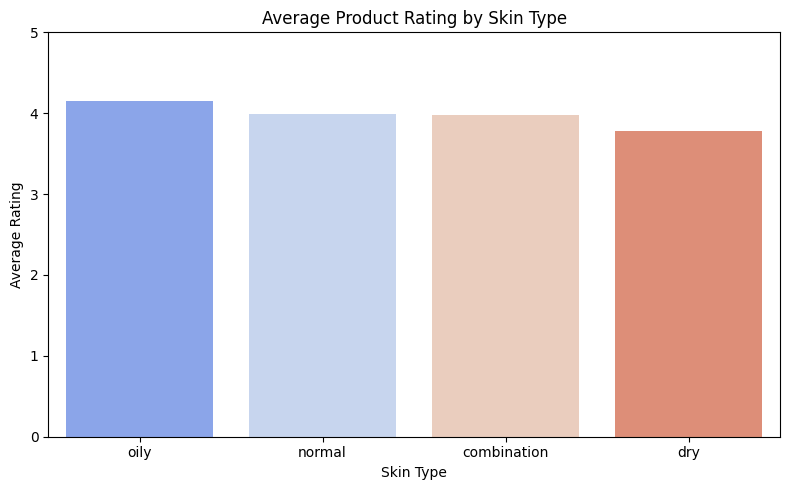

In [10]:
# Query to get average rating by skin type
query = """
SELECT
    ContextDataValues.skinType.Value AS skinType,
    AVG(rating) AS avg_rating,
    COUNT(*) AS count_reviews
FROM reviews_clean
WHERE rating IS NOT NULL
  AND ContextDataValues.skinType.Value IS NOT NULL
GROUP BY skinType
ORDER BY avg_rating DESC
"""

# Execute the query and get the result as a pandas DataFrame
df_skin_rating = conn.execute(query).df()

# Plotting average rating by skin type
plt.figure(figsize=(8, 5))
sns.barplot(data=df_skin_rating, x="skinType", y="avg_rating", palette="coolwarm")
plt.title("Average Product Rating by Skin Type")
plt.xlabel("Skin Type")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# Is there a relationship between skin tone and product ratings or recommendations?

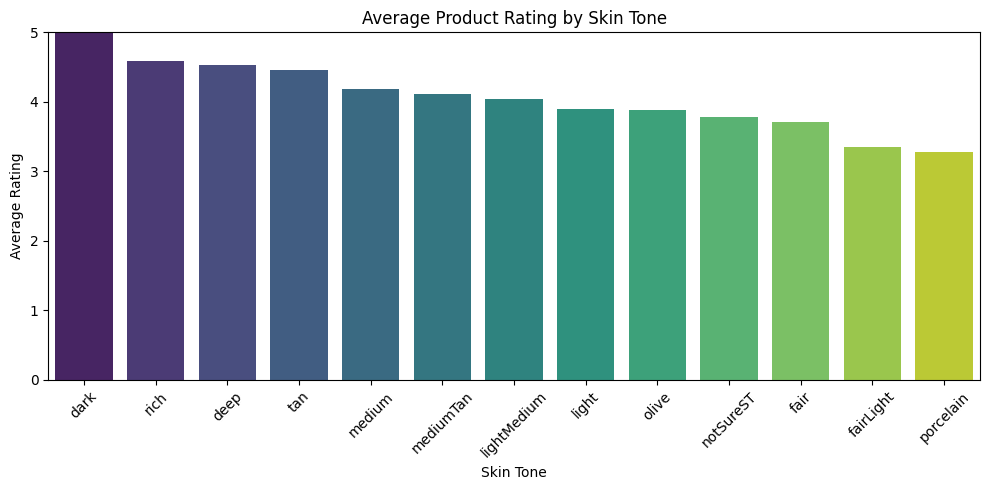

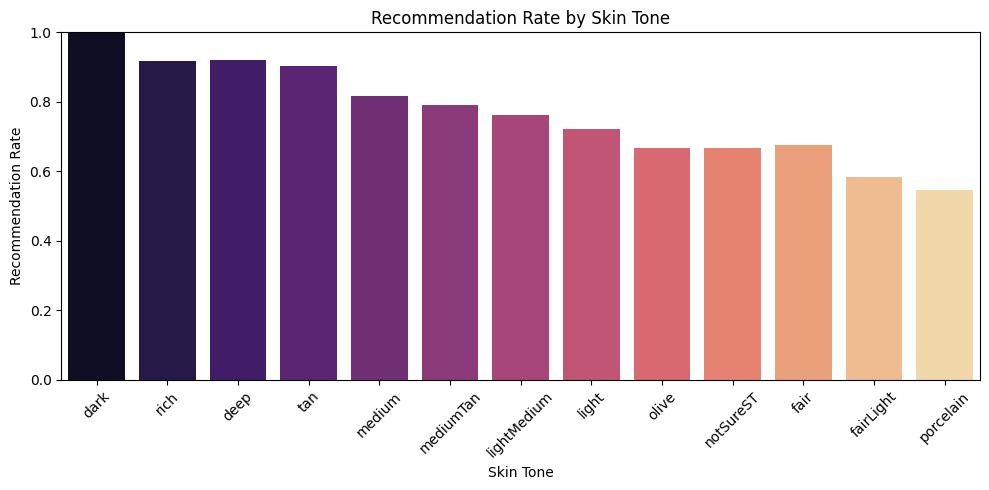

In [12]:
# Query to get average rating and recommendation rate by skin tone
query = """
SELECT
    ContextDataValues.skinTone.Value AS skinTone,
    AVG(rating) AS avg_rating,
    AVG(CASE WHEN isrecommended THEN 1 ELSE 0 END) AS recommendation_rate,
    COUNT(*) AS count_reviews
FROM reviews_clean
WHERE rating IS NOT NULL
  AND ContextDataValues.skinTone.Value IS NOT NULL
GROUP BY skinTone
ORDER BY avg_rating DESC
"""

# Execute the query using existing DuckDB connection `conn`
df_skin_tone = conn.execute(query).df()

# Plot average rating by skin tone
plt.figure(figsize=(10, 5))
sns.barplot(data=df_skin_tone, x="skinTone", y="avg_rating", palette="viridis")
plt.title("Average Product Rating by Skin Tone")
plt.xlabel("Skin Tone")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot recommendation rate by skin tone
plt.figure(figsize=(10, 5))
sns.barplot(data=df_skin_tone, x="skinTone", y="recommendation_rate", palette="magma")
plt.title("Recommendation Rate by Skin Tone")
plt.xlabel("Skin Tone")
plt.ylabel("Recommendation Rate")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# How does receiving the product as an incentivized review (free sample) influence rating and recommendation?

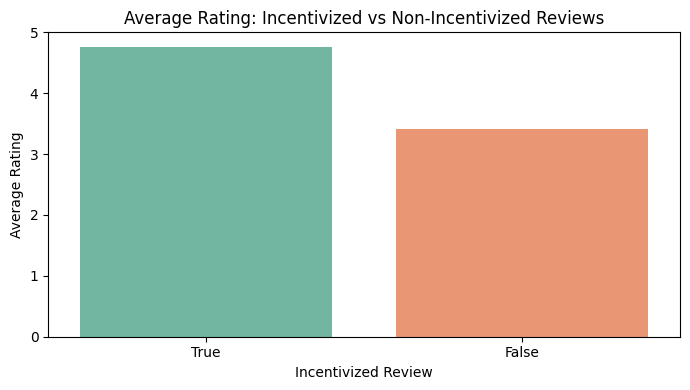

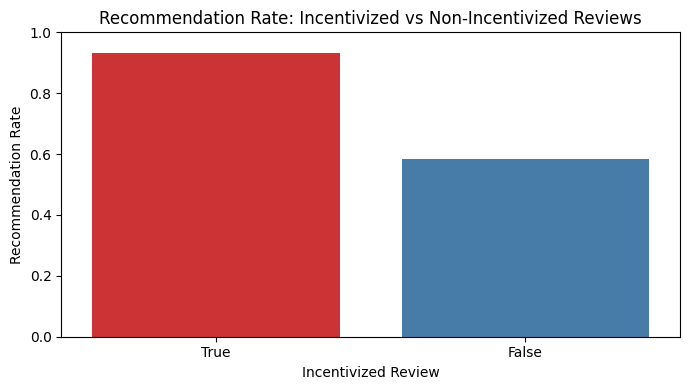

In [14]:
# Query to analyze the effect of incentivized reviews on ratings and recommendations
query = """
SELECT
    ContextDataValues.IncentivizedReview.Value AS IncentivizedReview,
    AVG(rating) AS avg_rating,
    AVG(CASE WHEN isrecommended THEN 1 ELSE 0 END) AS recommendation_rate,
    COUNT(*) AS count_reviews
FROM reviews_clean
WHERE rating IS NOT NULL
  AND ContextDataValues.IncentivizedReview.Value IS NOT NULL
GROUP BY IncentivizedReview
ORDER BY avg_rating DESC
"""

# Execute the query using the existing DuckDB connection `conn`
df_incentivized = conn.execute(query).df()

# Plot: Average rating by incentivized review status
plt.figure(figsize=(7, 4))
sns.barplot(data=df_incentivized, x="IncentivizedReview", y="avg_rating", palette="Set2")
plt.title("Average Rating: Incentivized vs Non-Incentivized Reviews")
plt.xlabel("Incentivized Review")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# Plot: Recommendation rate by incentivized review status
plt.figure(figsize=(7, 4))
sns.barplot(data=df_incentivized, x="IncentivizedReview", y="recommendation_rate", palette="Set1")
plt.title("Recommendation Rate: Incentivized vs Non-Incentivized Reviews")
plt.xlabel("Incentivized Review")
plt.ylabel("Recommendation Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# What are common themes or keywords in highly rated (4–5 stars) vs. poorly rated reviews (1–2 stars)? 

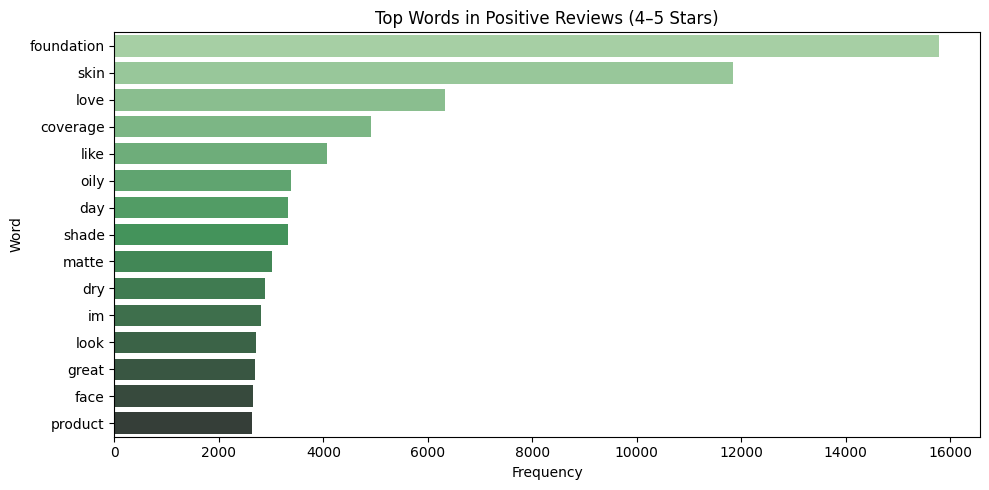

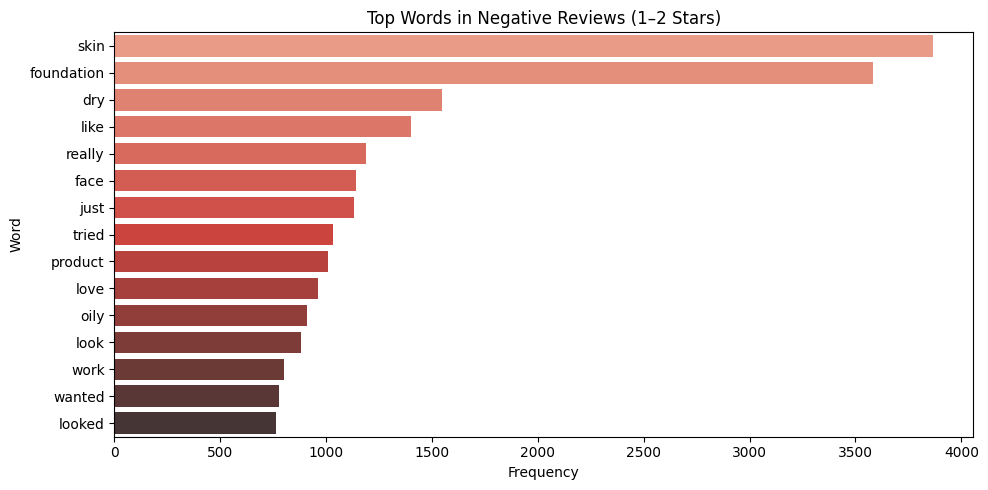

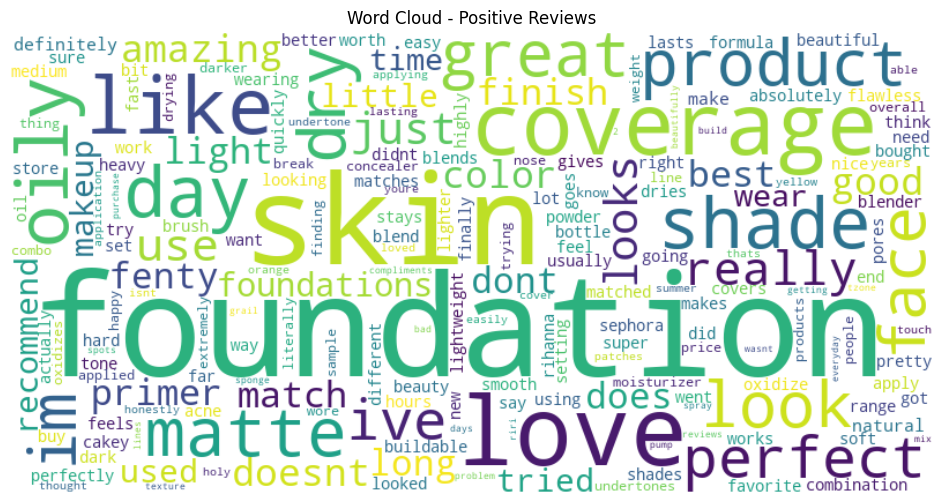

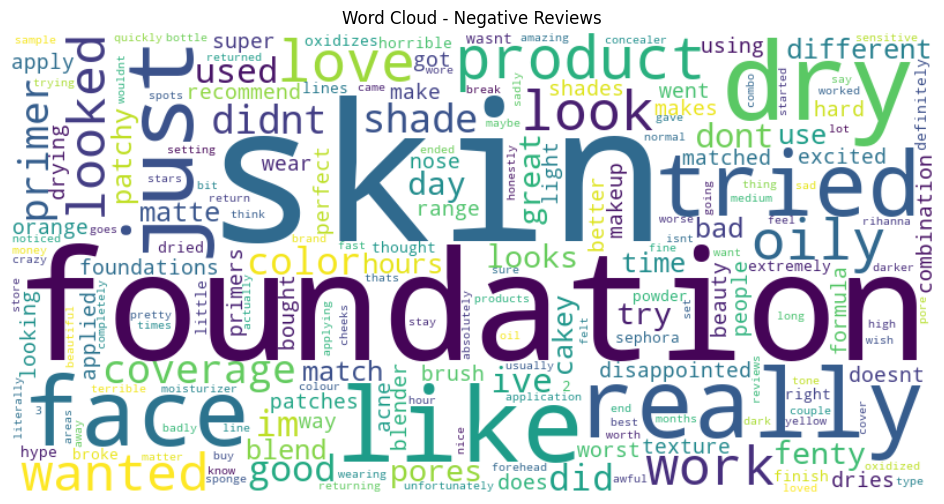

In [16]:
from collections import Counter
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Query to get review text and ratings
query = """
SELECT
    rating,
    reviewtext
FROM reviews_clean
WHERE rating IS NOT NULL AND reviewtext IS NOT NULL
"""

# Execute the query using `conn`
df_reviews = conn.execute(query).df()


# Preprocess text function
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    return tokens


# Filter positive and negative reviews
positive_reviews = df_reviews[df_reviews["rating"] >= 4]["reviewtext"].dropna().tolist()
negative_reviews = df_reviews[df_reviews["rating"] <= 2]["reviewtext"].dropna().tolist()

# Tokenize and flatten
positive_words = [word for review in positive_reviews for word in preprocess(review)]
negative_words = [word for review in negative_reviews for word in preprocess(review)]

# Count word frequencies
pos_counter = Counter(positive_words)
neg_counter = Counter(negative_words)

# Convert to DataFrame for plotting
pos_df = pd.DataFrame(pos_counter.most_common(15), columns=["word", "count"])
neg_df = pd.DataFrame(neg_counter.most_common(15), columns=["word", "count"])

# Plot top positive review words
plt.figure(figsize=(10, 5))
sns.barplot(data=pos_df, x="count", y="word", palette="Greens_d")
plt.title("Top Words in Positive Reviews (4–5 Stars)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# Plot top negative review words
plt.figure(figsize=(10, 5))
sns.barplot(data=neg_df, x="count", y="word", palette="Reds_d")
plt.title("Top Words in Negative Reviews (1–2 Stars)")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

# Optional: WordClouds
pos_wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(pos_counter)
neg_wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(neg_counter)

plt.figure(figsize=(12, 6))
plt.imshow(pos_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

plt.figure(figsize=(12, 6))
plt.imshow(neg_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

# What is the sentiment distribution (positive vs. negative) for reviews from different skin types or tones?

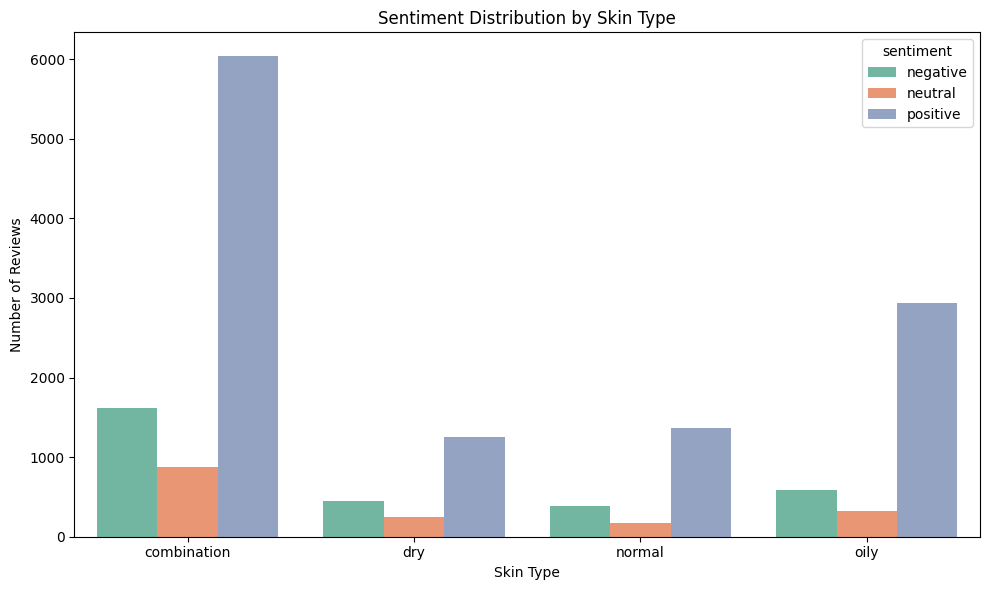

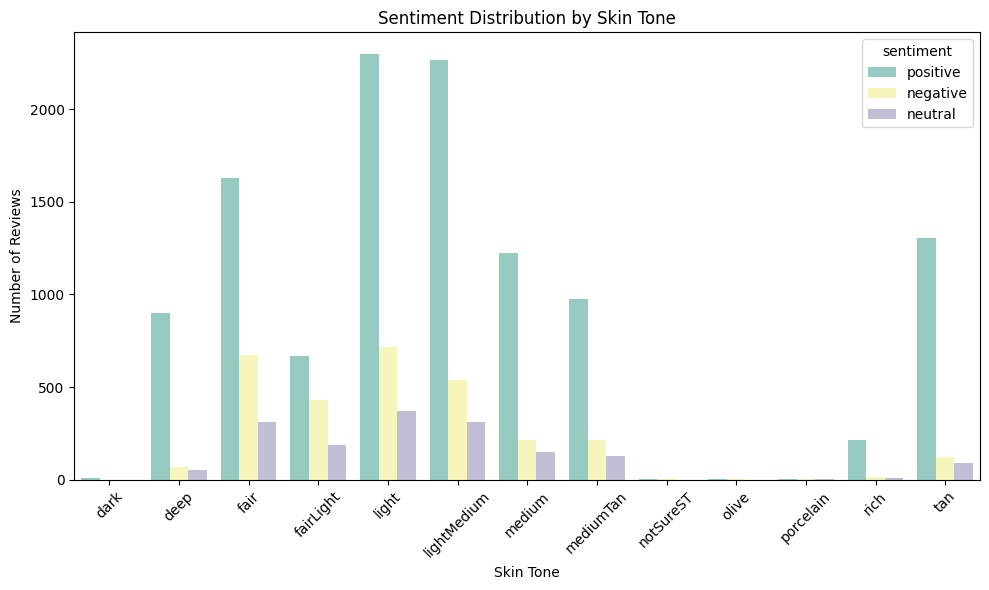

In [17]:
# Query to extract skin type, skin tone, and rating
query = """
SELECT
    ContextDataValues.skinType.Value AS skinType,
    ContextDataValues.skinTone.Value AS skinTone,
    rating
FROM reviews_clean
WHERE rating IS NOT NULL
  AND (ContextDataValues.skinType.Value IS NOT NULL OR ContextDataValues.skinTone.Value IS NOT NULL)
"""

# Execute the query using the existing connection
df_sentiment = conn.execute(query).df()

# Define sentiment label
df_sentiment["sentiment"] = df_sentiment["rating"].apply(
    lambda r: "positive" if r >= 4 else ("negative" if r <= 2 else "neutral")
)

# Sentiment distribution by skin type
skin_type_sentiment = (
    df_sentiment[df_sentiment["skinType"].notnull()].groupby(["skinType", "sentiment"]).size().reset_index(name="count")
)

plt.figure(figsize=(10, 6))
sns.barplot(data=skin_type_sentiment, x="skinType", y="count", hue="sentiment", palette="Set2")
plt.title("Sentiment Distribution by Skin Type")
plt.xlabel("Skin Type")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

# Sentiment distribution by skin tone
skin_tone_sentiment = (
    df_sentiment[df_sentiment["skinTone"].notnull()].groupby(["skinTone", "sentiment"]).size().reset_index(name="count")
)

plt.figure(figsize=(10, 6))
sns.barplot(data=skin_tone_sentiment, x="skinTone", y="count", hue="sentiment", palette="Set3")
plt.title("Sentiment Distribution by Skin Tone")
plt.xlabel("Skin Tone")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Does including more user context (like eye/hair/skin info) make a review more helpful or likely to be recommended?

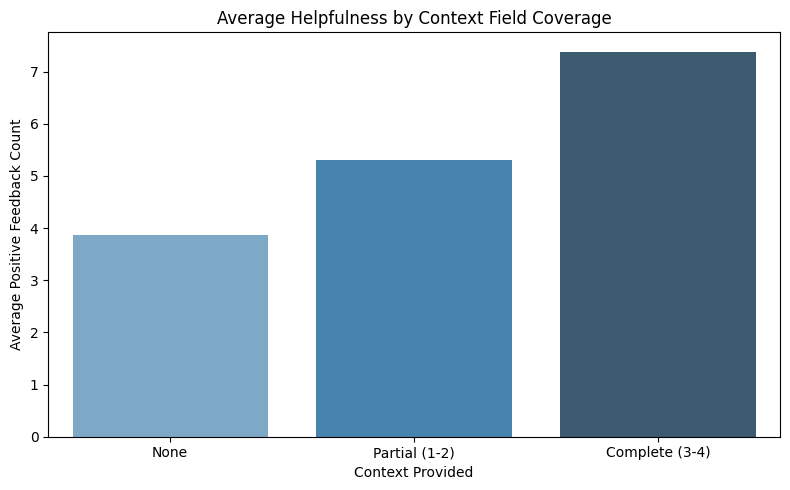

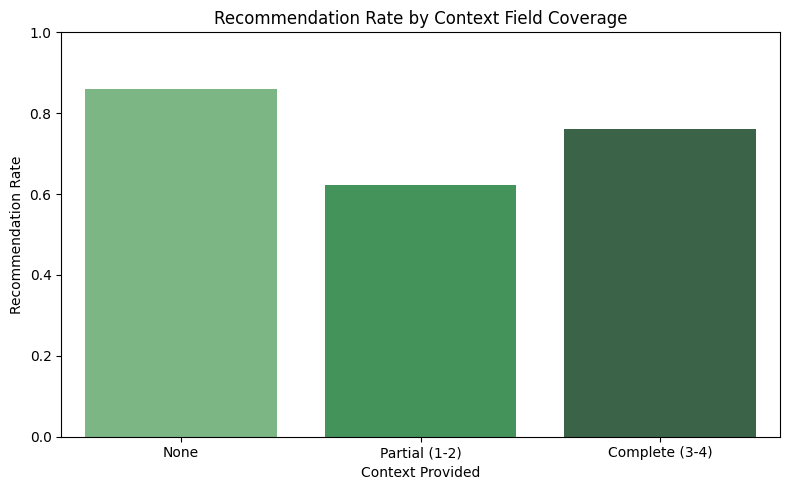

In [18]:
# Query to get context fields presence, helpfulness, and recommendation status
query = """
SELECT
    rating,
    isrecommended,
    TotalPositiveFeedbackCount,
    ContextDataValues.skinType.Value IS NOT NULL AS has_skinType,
    ContextDataValues.skinTone.Value IS NOT NULL AS has_skinTone,
    ContextDataValues.hairColor.Value IS NOT NULL AS has_hairColor,
    ContextDataValues.eyeColor.Value IS NOT NULL AS has_eyeColor
FROM reviews_clean
WHERE rating IS NOT NULL
"""

# Execute the query using the DuckDB connection
df_context = conn.execute(query).df()

# Count how many context fields each review provided
df_context["context_fields_count"] = df_context[["has_skinType", "has_skinTone", "has_hairColor", "has_eyeColor"]].sum(
    axis=1
)

# Create context coverage groups: 0, 1–2, 3–4 fields
df_context["context_group"] = pd.cut(
    df_context["context_fields_count"], bins=[-1, 0, 2, 4], labels=["None", "Partial (1-2)", "Complete (3-4)"]
)

# Calculate average helpfulness and recommendation rate by context group
group_stats = (
    df_context.groupby("context_group")
    .agg(
        avg_helpfulness=("TotalPositiveFeedbackCount", "mean"),
        recommendation_rate=("isrecommended", "mean"),
        count=("rating", "count"),
    )
    .reset_index()
)

# Plot: Helpfulness vs. context provided
plt.figure(figsize=(8, 5))
sns.barplot(data=group_stats, x="context_group", y="avg_helpfulness", palette="Blues_d")
plt.title("Average Helpfulness by Context Field Coverage")
plt.xlabel("Context Provided")
plt.ylabel("Average Positive Feedback Count")
plt.tight_layout()
plt.show()

# Plot: Recommendation rate vs. context provided
plt.figure(figsize=(8, 5))
sns.barplot(data=group_stats, x="context_group", y="recommendation_rate", palette="Greens_d")
plt.title("Recommendation Rate by Context Field Coverage")
plt.xlabel("Context Provided")
plt.ylabel("Recommendation Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

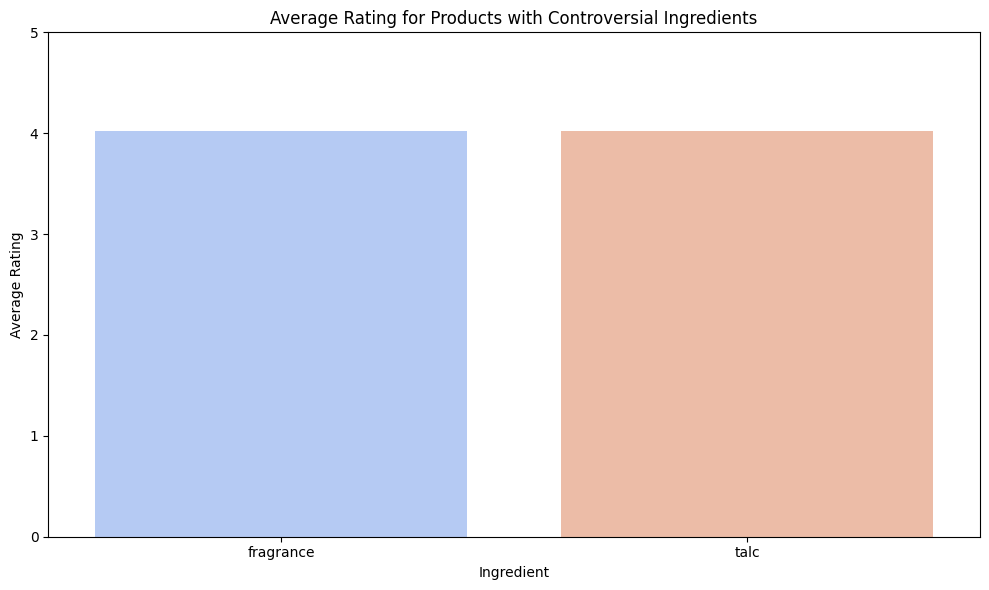

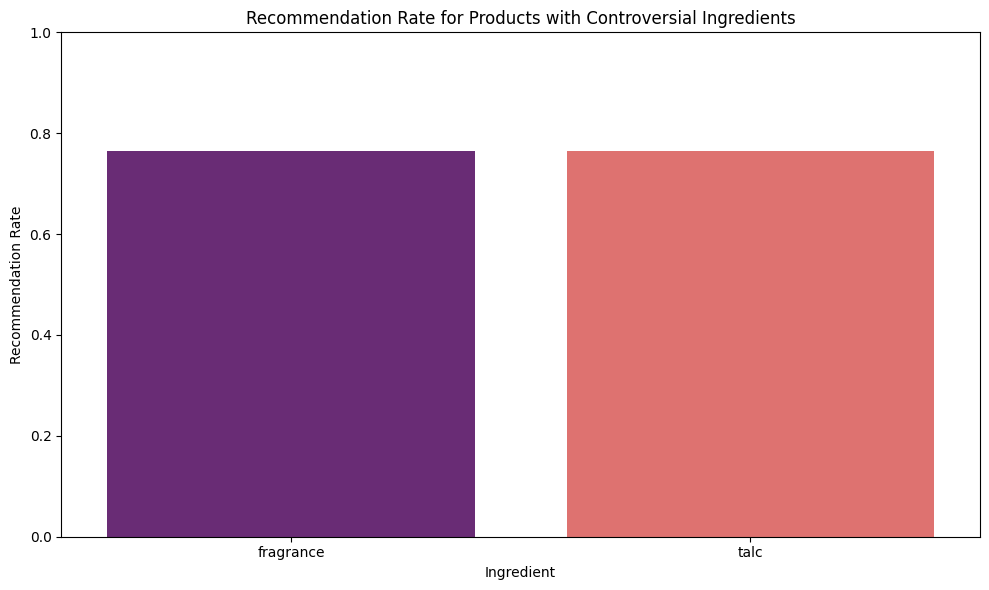

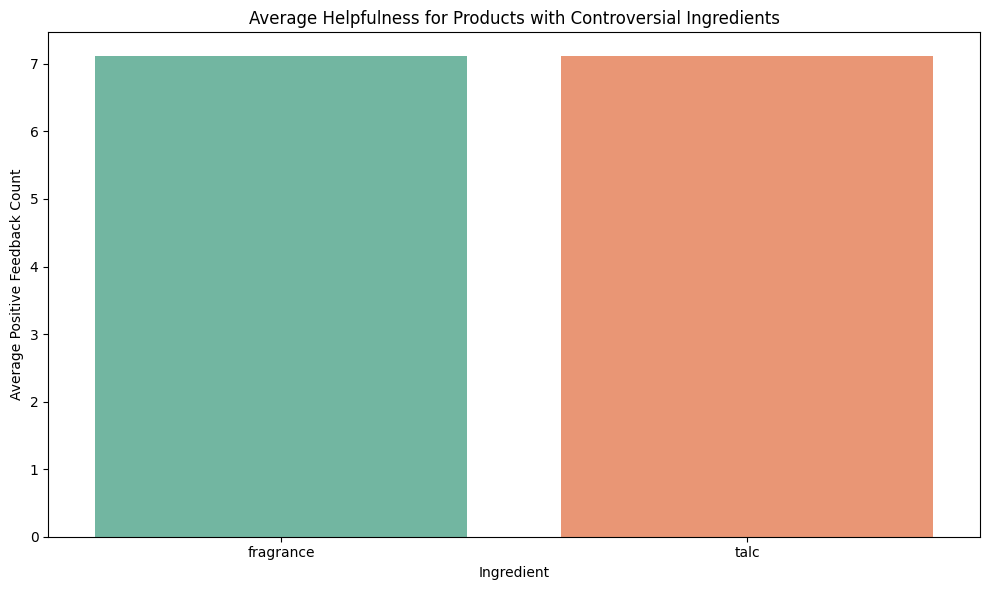

['paraben' 'fragrance' 'talc' 'phthalate' 'formaldehyde' 'mineral oil']


In [20]:
# Step 1: Load product info and review info
query = """
SELECT
    r.rating,
    r.isrecommended,
    r.TotalPositiveFeedbackCount,
    r.product_id,
    p.ingredients
FROM (select 'P87985432' as product_id,* from reviews_clean) r
JOIN products_raw p ON r.product_id = p.product_id
WHERE r.rating IS NOT NULL AND p.ingredients IS NOT NULL
"""

# Execute query
df_full = conn.execute(query).df()

# Step 2: Define controversial/harmful ingredients
controversial_ingredients = ["paraben", "fragrance", "talc", "phthalate", "formaldehyde", "mineral oil"]

# Step 3: Create ingredient flags
for ingr in controversial_ingredients:
    col_name = f'has_{ingr.replace(" ", "_")}'
    df_full[col_name] = df_full["ingredients"].str.contains(ingr, case=False, na=False)

# Step 4: Compare average rating, recommendation rate, and helpfulness for each ingredient
results = []

for ingr in controversial_ingredients:
    col = f'has_{ingr.replace(" ", "_")}'
    grouped = (
        df_full.groupby(col)
        .agg(
            avg_rating=("rating", "mean"),
            recommendation_rate=("isrecommended", "mean"),
            avg_helpfulness=("TotalPositiveFeedbackCount", "mean"),
            review_count=("rating", "count"),
        )
        .reset_index()
    )
    grouped["ingredient"] = ingr
    grouped["has_ingredient"] = grouped[col]  
    results.append(grouped)

# Combine results
df_impact = pd.concat(results, ignore_index=True)
# print(df_impact.head())
# Step 5: Plot average rating comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_impact[df_impact['has_ingredient'] == True], x="ingredient", y="avg_rating", palette="coolwarm")
plt.title("Average Rating for Products with Controversial Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Average Rating")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# Step 6: Plot recommendation rate comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_impact[df_impact['has_ingredient'] == True], x="ingredient", y="recommendation_rate", palette="magma")
plt.title("Recommendation Rate for Products with Controversial Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Recommendation Rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Step 7: Plot helpfulness score comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=df_impact[df_impact['has_ingredient'] == True], x="ingredient", y="avg_helpfulness", palette="Set2")
plt.title("Average Helpfulness for Products with Controversial Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Average Positive Feedback Count")
plt.tight_layout()
plt.show()

print(df_impact['ingredient'].unique())

#  Most used ingredients in the list of products

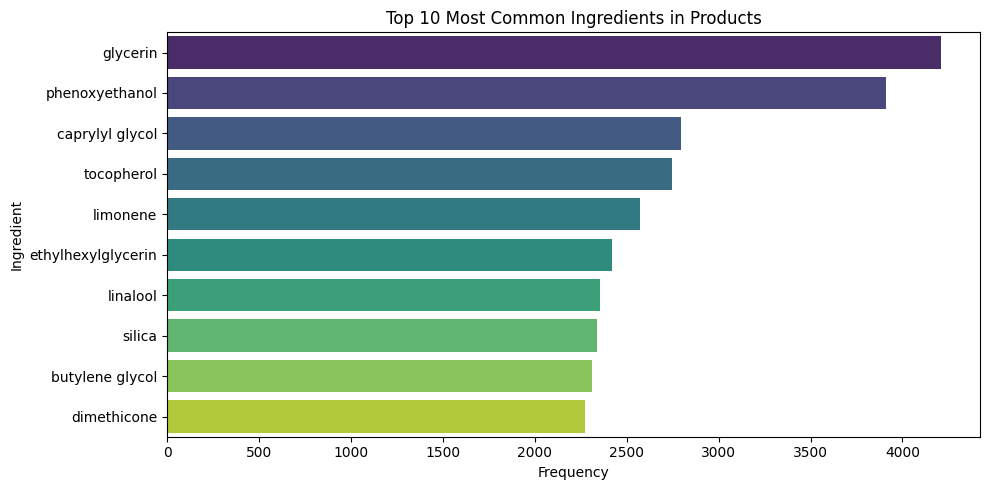

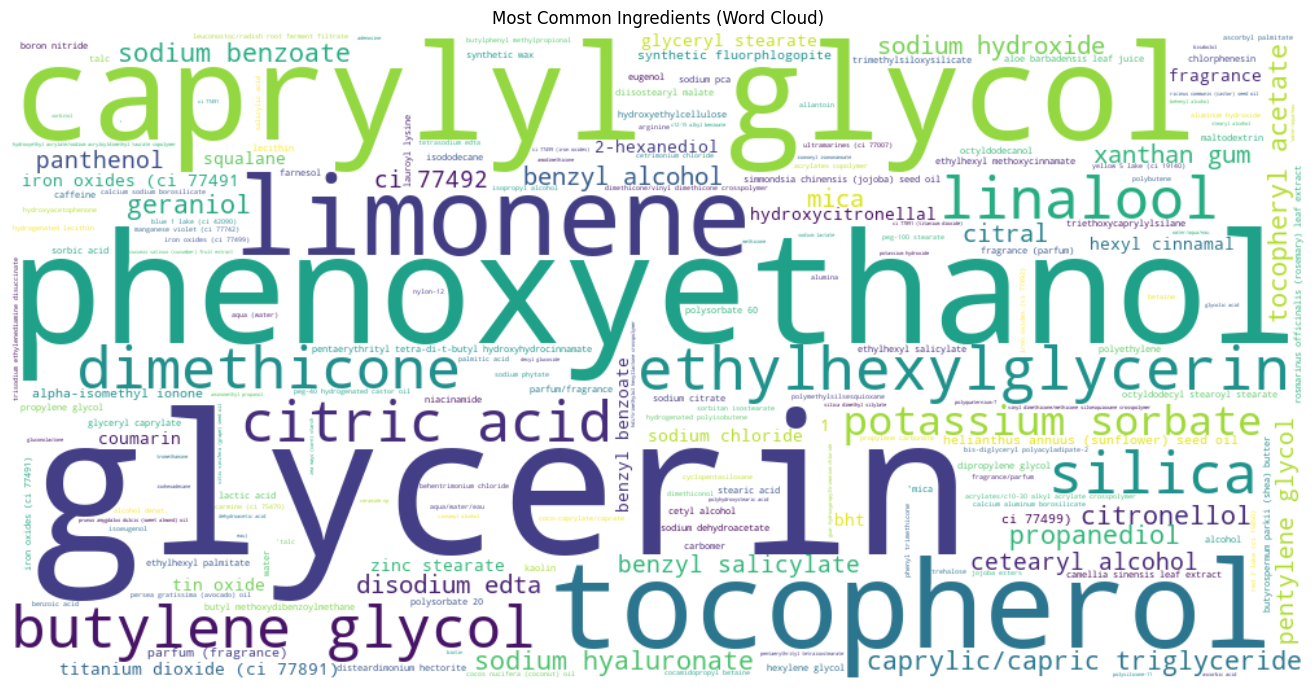

In [13]:
# Load ingredients
import re
from collections import Counter
from wordcloud import WordCloud

query = "SELECT ingredients FROM products_raw WHERE ingredients IS NOT NULL"
df_ingredients = conn.execute(query).df()

# Combine and tokenize ingredients
all_ingredients_text = ' '.join(df_ingredients['ingredients'].dropna().tolist()).lower()
ingredients_list = [ing.strip() for ing in re.split(r',|\n', all_ingredients_text) if ing.strip()]
ingredient_counts = Counter(ingredients_list)

# Top 10 ingredients
top_10_df = pd.DataFrame(ingredient_counts.most_common(10), columns=['ingredient', 'count'])

# Histogram
plt.figure(figsize=(10, 5))
sns.barplot(data=top_10_df, x='count', y='ingredient', palette='viridis')
plt.title('Top 10 Most Common Ingredients in Products')
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.tight_layout()
plt.show()

# Word Cloud
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate_from_frequencies(ingredient_counts)
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Ingredients (Word Cloud)')
plt.tight_layout()
plt.show()


# Can we build a predictive model to estimate the probability of a product being purchased based on its reviews, likes, price, and ingredients?

In [14]:
# Step 1: Query and join product + review data for modeling
query = """
SELECT
    r.rating,
    r.isrecommended,
    r.TotalPositiveFeedbackCount,
    coalesce(r.helpfulness,0.0) as helpfulness,
    r.product_id,
    p.price_usd,
    p.ingredients
FROM (select 'P87985432' as product_id,* from reviews_clean) r
JOIN products_raw p ON r.product_id = p.product_id
WHERE r.rating IS NOT NULL AND p.ingredients IS NOT NULL AND p.price_usd IS NOT NULL
"""

# Load data from DuckDB
df_model = conn.execute(query).df()

# Step 2: Create target label (purchase intent)
df_model["purchase_intent"] = (df_model["isrecommended"]) & (df_model["rating"] >= 4)

# Step 3: Ingredient flags
ingredient_keywords = ["paraben", "fragrance", "talc", "phthalate", "formaldehyde", "mineral oil"]
for ingr in ingredient_keywords:
    col = f'has_{ingr.replace(" ", "_")}'
    df_model[col] = df_model["ingredients"].str.contains(ingr, case=False, na=False)

# Step 4: Select features and target
feature_cols = ["rating", "TotalPositiveFeedbackCount", "helpfulness", "price_usd"] + [
    f'has_{ingr.replace(" ", "_")}' for ingr in ingredient_keywords
]

X = df_model[feature_cols]
y = df_model["purchase_intent"]

# Step 5: Split data and train logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 6: Evaluate model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_prob)

# Step 7: Output evaluation metrics and feature importances
import pandas as pd

# Feature importances
coef_df = pd.DataFrame({"feature": X.columns, "coefficient": model.coef_[0]}).sort_values(
    by="coefficient", ascending=False
)

report_summary = {"classification_report": report, "roc_auc_score": roc_auc, "feature_importance": coef_df}


report_summary

{'classification_report': {'False': {'precision': 1.0,
   'recall': 0.9894291754756871,
   'f1-score': 0.9946865037194474,
   'support': 946.0},
  'True': {'precision': 0.9960906958561376,
   'recall': 1.0,
   'f1-score': 0.9980415197806503,
   'support': 2548.0},
  'accuracy': 0.9971379507727532,
  'macro avg': {'precision': 0.9980453479280689,
   'recall': 0.9947145877378436,
   'f1-score': 0.9963640117500489,
   'support': 3494.0},
  'weighted avg': {'precision': 0.9971491393936573,
   'recall': 0.9971379507727532,
   'f1-score': 0.9971331496621907,
   'support': 3494.0}},
 'roc_auc_score': np.float64(0.9985483785317674),
 'feature_importance':                       feature  coefficient
 0                      rating     7.401274
 1  TotalPositiveFeedbackCount     0.001820
 4                 has_paraben     0.000000
 7               has_phthalate     0.000000
 8            has_formaldehyde     0.000000
 9             has_mineral_oil     0.000000
 5               has_fragrance    -0.

In [ ]:
import joblib

# Save model and features
model_path = "purchase_intent_model.pkl"
features_path = "purchase_intent_features.pkl"
joblib.dump(model, model_path)
joblib.dump(feature_cols, features_path)

In [21]:
conn.close()